# Predator-Prey

We take the earlier developed model of "Commited moose" (the ones that move in a straight line, and get reflected by enclosure borders). But also even before starting the movement, we mark all animals in one corner. It's like as if we captured them, marked them, and released them.

And then at some point in time we trap them again (look at all animals in this corner), count how many of them are marked (how many of them were captured before), and use this info to estimate the number of animals in the system.

(Here we of course have the God-like knowledge of the true number of animals in the system, so what we are trying to check is whether an estimation an ecologist would have made would have been reasonable.)

We'll use the following formula for the estimation (taken from Wikipedia): ${\displaystyle {\hat {N}}_{C}={\frac {(K+1)(n+1)}{k+1}}-1}$

And then, in practice, we'll make our 'fake ecologist' estimate the number of animals in the system at every step of the loop. Not because they would do so in practice (in practice they would have waited for some time of course, and then they would have re-traped the animals once or twice), but just because we can do it. And it can lead to useful predictions, like, when should an ecologist retrap the animals? How long should they wait?

Changes vs previous version:
* All constants moved from global variables to a class, as class properties
* The model is made into a function
* The "running dotses" visualization is made conditional (so we haven't deleted it completely), but it is now inactivated by default

In [3]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
##### Define constants, but we do it as a class (to later make passing it around easier)

class Const: #Carefree remote-eating cheaters
    def __init__(self):
        self.n_animals_max = 2000
        self.n_animals_start = 10  #Original n_animals
        self.n_steps = 500
        self.vmin = 0.01
        self.vmax = 5*self.vmin
        self.v_decay = 0.7
        self.arena_size = 3
        
        self.hp_baby = 20
        self.hp_food = 10
        self.hp_reproduction = 50
        self.hp_birthcost = 15        
        self.hp_leak = 0.7
        
        self.food_rate = np.round(1*self.arena_size**2)
        self.eating_distance = 0.1**2       #To avoid running np.sqrt() later
        self.n_food_max = 10000
        self.n_food_start = 200*9
        

In [9]:
#Build the model

def model(c, show_dotses=False, n_trials=1):
    history = np.zeros((c.n_steps, n_trials))

    for i_trial in range(n_trials):
        #Allocate hp for all animals, but only first few are alive
        hp = np.zeros(c.n_animals_max)
        hp[:c.n_animals_start] = np.random.uniform(
            low=c.hp_baby, high=c.hp_reproduction, size=c.n_animals_start)
        
        x = np.random.uniform(low=0, high=c.arena_size, size=c.n_animals_max)
        y = np.random.uniform(low=0, high=c.arena_size, size=c.n_animals_max)
        vx = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        vy = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        
        #Let there be cabbage!
        foodx = np.ones(c.n_food_max)*-1
        foodx[:c.n_food_start] = np.random.uniform(low=0, high=c.arena_size, size=c.n_food_start)
        foody = np.random.uniform(low=0, high=c.arena_size, size=c.n_food_max) 
        #Y doen't matter coz x=-1 is enough to move cabbage out of this world
        
        n_animals = np.zeros(c.n_steps)

        if show_dotses: #Init plots
            fig = plt.figure(figsize=(3,3))
            ax = plt.subplot(111) #No subplots; just creating axes
            plt.xlim((0,c.arena_size));
            plt.ylim((0,c.arena_size));
            fig.show()
            fig.canvas.draw()

        for t in range(c.n_steps):
            x += vx
            y += vy
            
            vx = vx*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin 
            vy = vy*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin
            #Make them run around (keeps speed somewhat randomized)

            #Reflect from the walls
            vx = np.where(np.logical_or(x>c.arena_size, x<0), -vx , vx)
            vy = np.where(np.logical_or(y>c.arena_size, y<0), -vy , vy)
            x = np.maximum(0,np.minimum(x, c.arena_size)) #Keep them in enclosure
            y = np.maximum(0,np.minimum(y, c.arena_size))
            
            potential_babies = np.argwhere(hp<=0)
            baby_counter = 0
            for i_animal in np.argwhere(hp>0): #This gains about a second of performance                    
                
                #But this little trick below makes things 10 times faster!!!
                d = np.square(foodx-x[i_animal]) + np.square(foody-y[i_animal])
                food_list = np.argwhere(d < c.eating_distance)
                hp[i_animal] += food_list.size*c.hp_food
                foodx[food_list] = -1
                
                if hp[i_animal]>=c.hp_reproduction: #Healthy enough to have a baby
                    hp[i_animal] -= c.hp_birthcost                 
                    if baby_counter < len(potential_babies): #There are still baby-slots on the list
                        ind = potential_babies[baby_counter] #Shortcut
                        baby_counter += 1                    #Count the baby
                        hp[ind] = c.hp_baby
                        x[ind] = x[i_animal]
                        y[ind] = y[i_animal]
                        vx[ind] = vx[i_animal]
                        vy[ind] = vy[i_animal]
                
            #Let cabbage grow! 
            potential_cabbage = np.argwhere(foodx<0)
            for i_cabbage in range(min(c.food_rate, potential_cabbage.size)):
                foodx[potential_cabbage[i_cabbage]] = np.random.uniform(low=0, high=c.arena_size)
                foody[potential_cabbage[i_cabbage]] = np.random.uniform(low=0, high=c.arena_size)
                
            hp -= c.hp_leak #Death
            
            n_animals[t] = np.sum(hp>0)
            
            if show_dotses: #Actual animation
                ax.clear()
                plt.plot(x[hp>0], y[hp>0], 'k.',markersize=5);
                plt.plot(foodx,foody,'r.', markersize=2)
                plt.xlim((0,c.arena_size));
                plt.ylim((0,c.arena_size));
                fig.canvas.draw() #Redraws the canvas (key secret command to animate things)
            else:
                print('.',end='')
        #Time loop is over

        history[:,i_trial] = n_animals
    return np.mean(history, axis=1)

<IPython.core.display.Javascript object>


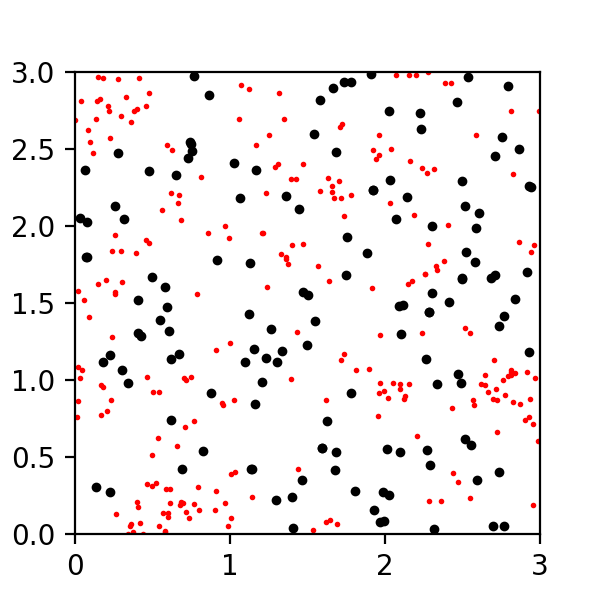

<IPython.core.display.Javascript object>


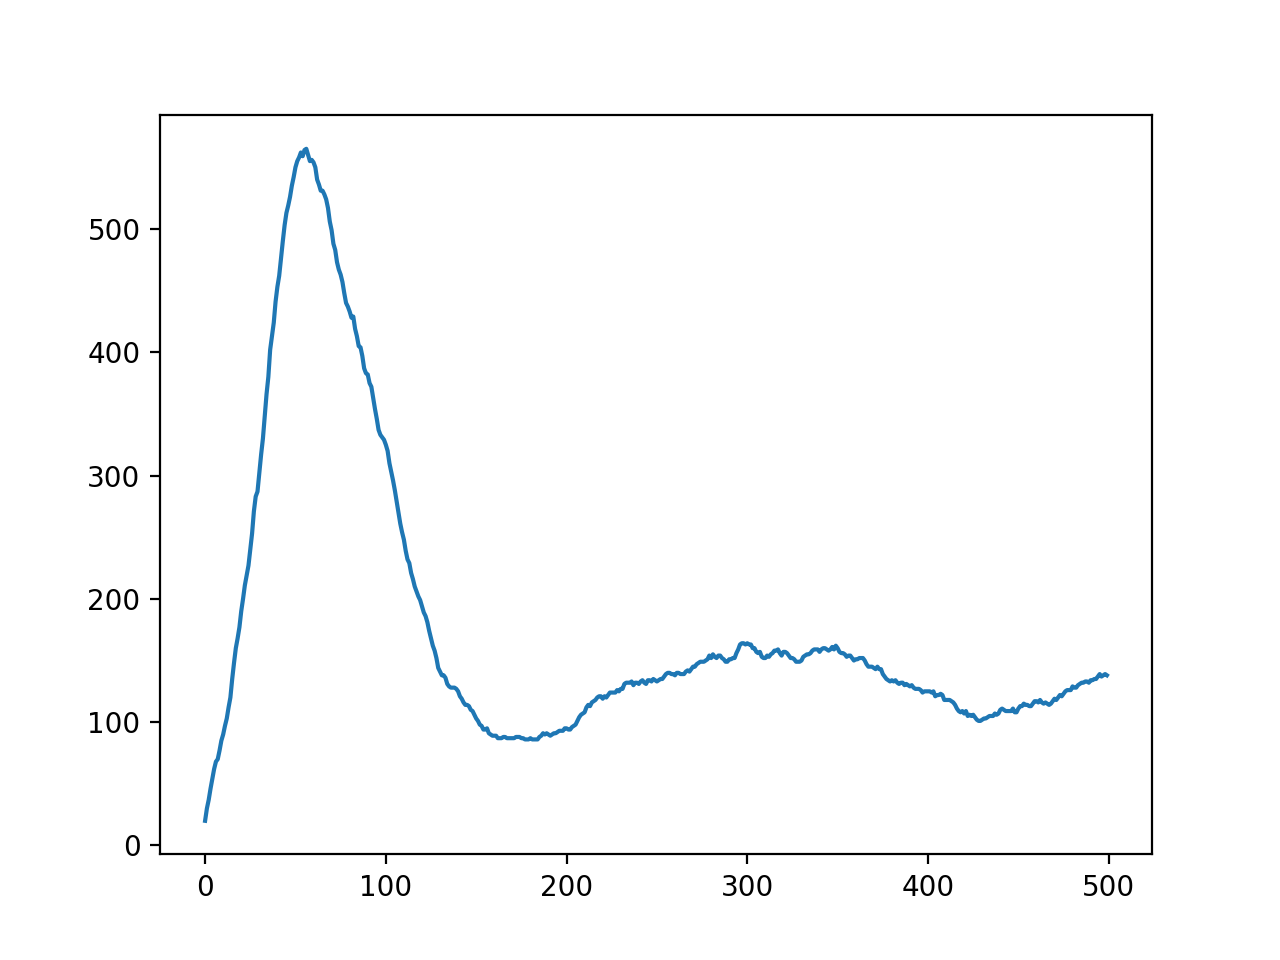

In [10]:
#Main program
c = Const();
np.random.seed(1)
curve  = model(c, show_dotses=True);
plt.figure();
plt.plot(curve);